Amazon Fine Food Reviews - Data Exploration
=======================

*Objective*

This notebook is created to make inferences on the Amazon fine Food reviews

In [1]:
import sqlite3
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from __future__ import print_function
%matplotlib inline
sns.set(style="white")

In [2]:
con = sqlite3.connect('./input/database.sqlite')
reviews = pd.read_sql_query("""
SELECT Id, ProductId, UserId, ProfileName, HelpfulnessNumerator, HelpfulnessDenominator, Score, Summary, Text, Time
FROM Reviews
""", con)
reviews.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Summary,Text,Time
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,1303862400
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,1346976000
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,"""Delight"" says it all",This is a confection that has been around a fe...,1219017600


Time seems to be in epoch time, let's convert that into a more readable format.

In [3]:
reviews['Time'] = pd.to_datetime(reviews['Time'], unit='s')
reviews['Year'] = pd.DatetimeIndex(reviews['Time']).year
reviews['Month'] = pd.DatetimeIndex(reviews['Time']).month
reviews['WordCount'] = map(lambda x: len(x.split()), reviews['Text'])

### Review score distribution

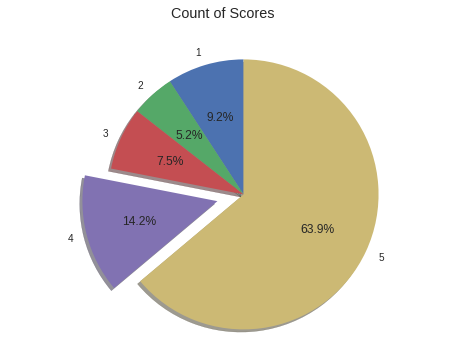

In [4]:
fig1, ax1 = plt.subplots()
labels = ['1', '2', '3', '4', '5']
explode=(0,0,0,0.2,0)
ax1.pie(reviews.groupby('Score')[['Id']].count(), explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.suptitle('Count of Scores')

Hmmm about 64 % of all reviews were given a rating of 5. It seems most of the reviewers are either very generous while giving their ratings or they are only providing ratings when it is a memorable experience. 

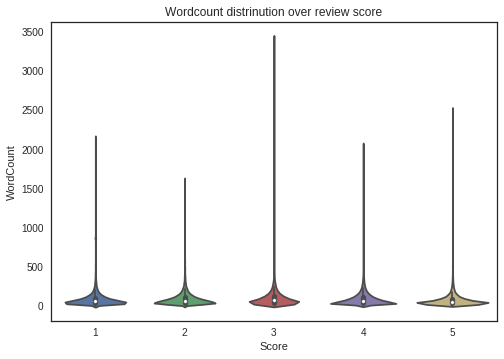

In [21]:
ax = sns.violinplot(x='Score', y='WordCount', data=reviews)
ax.set_title('Wordcount distrinution over review score')

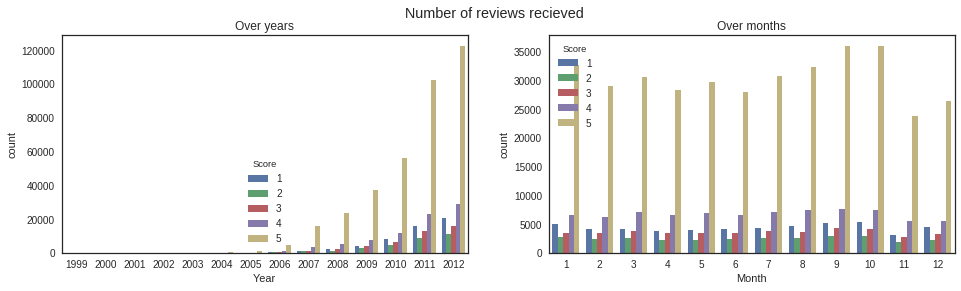

In [6]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
sns.countplot(x='Year', hue='Score', data=reviews, ax=ax1)
sns.countplot(x='Month', hue='Score', data=reviews, ax=ax2)
ax1.set_title("Over years")
ax2.set_title("Over months")
plt.suptitle("Number of reviews recieved")

In [7]:
print("Number of unique reviewers: {0} \nNumber of unique products: {1}".format(reviews['UserId'].nunique(), reviews['ProductId'].nunique()))

Number of unique reviewers: 256059 
Number of unique products: 74258


So, out of 568454 reviews we have nearly half as much unique users who wrote those reviews.

In [8]:
count_df = pd.DataFrame({'count' : reviews.groupby(['UserId']).size()}).reset_index()

In [9]:
assert(len(count_df[count_df['count'] > 10]) / float(len(reviews)) < 0.02)

In [28]:
len(count_df[count_df['count'] > 10]) /float(len(count_df))

0.02483412026134602

256059

Helpfulness of a comment
---------------------------

The helpfullness of a review is something that is hard to determine when it gets posted.
Over time after multiple users read through it and decidee tto vote on whether this particular review is helpful or not, 
do we actually get to know of that review's helpfulness.

Knowledge of helpfulness of reviews is very advantageous. For instance if the top reviews are all very helpful, it can potentially drive other customers towards it or away from it.

Let's first take a look at it's distribution.

In [10]:
helpfulness_df = reviews[reviews['HelpfulnessDenominator'] >= 10][['Id', 'UserId', 'Text', 'Summary', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'WordCount']]

In [11]:
helpfulness_df['HelpfulnessDenominator'].fillna(0, inplace=True)
helpfulness_df['HelpfulnessNumerator'].fillna(0, inplace=True)
helpfulness_df['HelpfulnessRatio'] = np.divide(helpfulness_df['HelpfulnessNumerator'].astype(float), helpfulness_df['HelpfulnessDenominator'])
helpfulness_df['HelpfulnessRatio'].fillna(0, inplace=True)

helpfulness_df['HelpfulnessRatio'].describe()

count    24982.000000
mean         0.763763
std          0.291560
min          0.000000
25%          0.647059
50%          0.900000
75%          1.000000
max          1.000000
Name: HelpfulnessRatio, dtype: float64

It seems maximum of Helpfulness ratio is showing values greater than 1, which is not expected. 

In [12]:
helpfulness_df['HelpfulnessRatio'] = [1 if x > 1.0 else x for x in  helpfulness_df['HelpfulnessRatio']]

In [13]:
helpfulness_df['Summary_wc'] = map(lambda x: len(x.split()), helpfulness_df['Summary'])

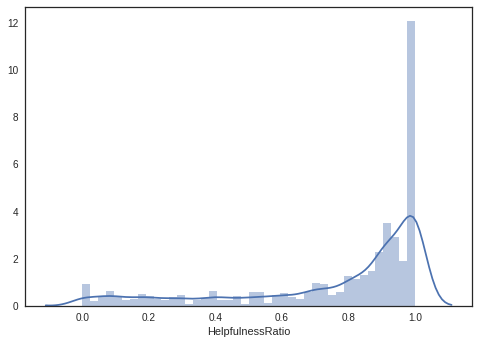

In [14]:
sns.distplot(helpfulness_df['HelpfulnessRatio'])

Let's try to see if number of words has any relationship with helpfulness.

In [15]:
helpfulness_df['CharCount'] = map(lambda x: len(x), helpfulness_df['Text'])
helpfulness_df['SentenceCount'] = map(lambda x: len(x.splitlines()), helpfulness_df['Text'])
helpfulness_df['PunctuationCount'] = map(lambda x: sum([1 for y in x if y in string.punctuation]), helpfulness_df['Text'])

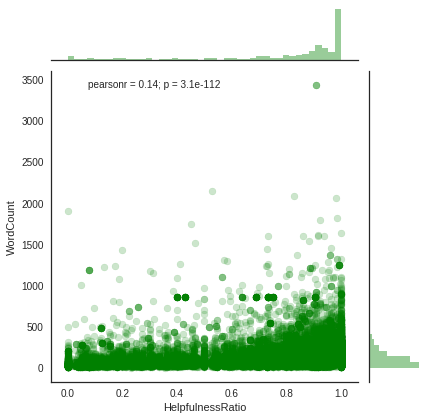

In [16]:
sns.jointplot(x='HelpfulnessRatio', y='WordCount', data=helpfulness_df, color='green', joint_kws={'alpha': 0.2})

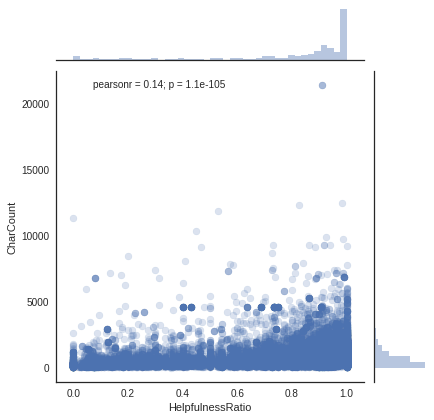

In [17]:
sns.jointplot(x='HelpfulnessRatio', y='CharCount', data=helpfulness_df, joint_kws={'alpha': 0.2})

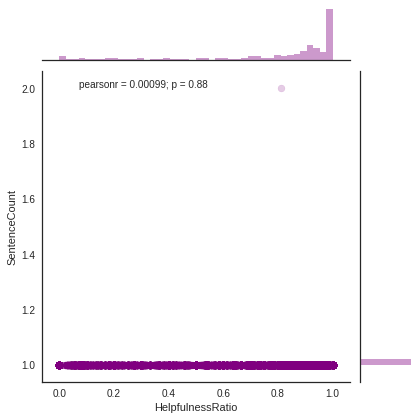

In [18]:
sns.jointplot(x='HelpfulnessRatio', y='SentenceCount', data=helpfulness_df, color='purple', joint_kws={'alpha': 0.2})

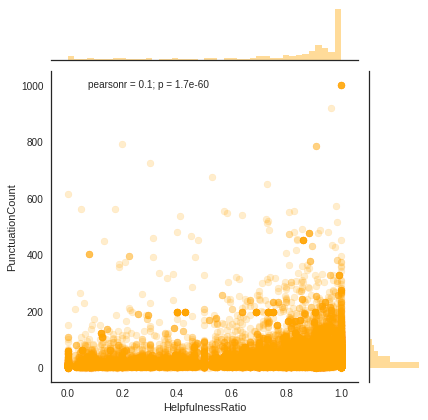

In [19]:
sns.jointplot(x='HelpfulnessRatio', y='PunctuationCount', data=helpfulness_df, color='orange', joint_kws={'alpha': 0.2})

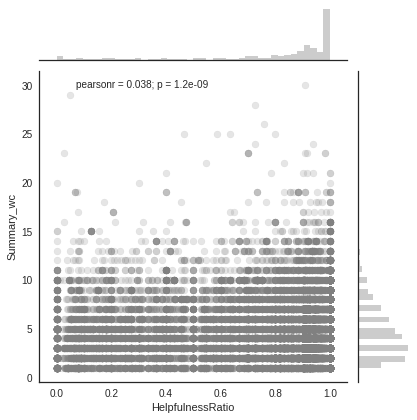

In [23]:
ax = sns.jointplot(x='HelpfulnessRatio', y='Summary_wc', data=helpfulness_df, color='grey', joint_kws={'alpha': 0.2})
#ax.set_title('HelpfulnessRatio vs Summary word-count distribution')